In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import backend 

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model


import matplotlib.pyplot as plt
import librosa
import librosa.display
import pickle
import numpy as np
import mne
import os
import cv2
import random
import math
import shutil

In [2]:
IMG_SHAPE = (128, 320, 3)
BATCH_SIZE = 8
PARTIAL_IMG_SHAPE = (128, 32, 3)

latent_dim = 128
num_diff_labels = 4
num_label_channels_generator = 32
generator_label_embedding_layer_size = 4
epochs = 20000

train_ratio = 0.8
val_ratio = 0.1

In [ ]:
def train_test_spliter(addr, train_ratio, val_ratio):
    
    files = os.listdir(addr)
    number_of_files = len(files)
    random.shuffle(files)
    end_of_train_files = math.floor(train_ratio*number_of_files)
    train_files = files[0:end_of_train_files]
    validation_files = files[end_of_train_files:end_of_train_files+math.floor(val_ratio*number_of_files)]
    test_files = files[end_of_train_files+math.floor(val_ratio*number_of_files):]
    
    return train_files, validation_files, test_files


class labeled_data_generator(keras.utils.Sequence):
    
    def __init__(self, data_files_addr, features_files_addr,batch_size=64):
        #self.train_data = train_data.reshape(train_data.shape[0], *PARTIAL_IMG_SHAPE).astype("float32")
        #self.train_data = (self.train_data-127.5)/127.5
        self.data_files_addr = data_files_addr
        self.batch_size = batch_size
        self.feature_files_addr = features_files_addr
        self.data_files = list()
        self.data_labels = list()
        
        self._read_files()

    
    def _read_files(self): 
        for file_addr in self.data_files_addr:
            with open(self.feature_files_addr+file_addr, 'rb') as handle:
                loaded_data = pickle.load(handle)
                self.data_files.append((loaded_data["data"].astype("float32")*2.0)-1.0)
                
                labels = np.reshape(np.round(loaded_data["labels"]*2)/2, (4, 1))
                labels = label_layer_generator(labels)
                self.data_labels.append(labels.astype("float32"))
        
    def __len__(self):
        return int(np.floor(len(self.data_files_addr) / (self.batch_size)))

    def __getitem__(self, index):
        
        batch_data, batch_labels = self.__data_generation(index) 
        
        return batch_data, batch_labels

    

    def __data_generation(self, index):
                 
        return (np.array(self.data_files[index*self.batch_size:(index+1)*self.batch_size]), np.array(self.data_labels[index*self.batch_size:(index+1)*self.batch_size])) 
    

def label_layer_generator(labels):
    one_hot_labels = np.zeros(( generator_label_embedding_layer_size,
                               generator_label_embedding_layer_size,
                              labels.shape[0]*num_label_channels_generator))
    
    
    for label_index, label in enumerate(labels):
        grid_number = int((label_index*num_label_channels_generator)+
                          np.round((label/9)*(num_label_channels_generator-1)))
        one_hot_labels[:, :, grid_number] = np.ones((1, generator_label_embedding_layer_size,
                                                     generator_label_embedding_layer_size)) 
    
    return one_hot_labels


def get_critic_model():
    
    input_label = tf.keras.layers.Input(shape=(generator_label_embedding_layer_size, 
                                               generator_label_embedding_layer_size,
                                              num_label_channels_generator*num_diff_labels,))
    
    embedded_layer = tf.keras.layers.Resizing(IMG_SHAPE[0], IMG_SHAPE[1], interpolation="bilinear")(input_label)
    
    n_nodes = IMG_SHAPE[0]*IMG_SHAPE[1]*num_label_channels_generator
    

    critic_input = layers.Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3))
    
    merge = tf.keras.layers.Concatenate()([critic_input, embedded_layer])
    
    critic = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding="same")(merge)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    critic = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding="same")(critic)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    critic = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same")(critic)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    critic = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(critic)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    critic = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(critic)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    critic = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same")(critic)
    critic = tf.keras.layers.LeakyReLU(alpha=0.2)(critic)
    
    
    critic = tf.keras.layers.Flatten()(critic)
    critic = tf.keras.layers.Dropout(0.4)(critic)
    critic = tf.keras.layers.Dense(1)(critic)
    
    
    
    c_model = keras.models.Model([critic_input, input_label], critic)
    
    return c_model


def get_generator_model():
    
    input_label = tf.keras.layers.Input(shape=(generator_label_embedding_layer_size, 
                                               generator_label_embedding_layer_size,
                                              num_label_channels_generator*num_diff_labels))
    
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(2 * 2 * 512, use_bias=False)(noise)
    
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((2, 2, 512))(x)
    

    
    
    gen = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    
    channels_input = list()
    channels_output = list()
    
    for channel_index in range(5):
        channel_input = tf.keras.layers.Concatenate()([gen, input_label])
        
        channels_input.append(channel_input)
        
        channel_path = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 1), padding="same")(channel_input)
        channel_path = tf.keras.layers.LeakyReLU(alpha=0.2)(channel_path)
    
    
        channel_path = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same")(channel_path)
        channel_path = tf.keras.layers.LeakyReLU(alpha=0.2)(channel_path)
        
        input_label_resize = tf.keras.layers.Resizing(2*2*generator_label_embedding_layer_size, 
                                               2*1*generator_label_embedding_layer_size, 
                                               interpolation="bilinear")(input_label)
        
        channel_path = tf.keras.layers.Concatenate()([channel_path, input_label_resize])
    
    
        channel_path = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same")(channel_path)
        channel_path = tf.keras.layers.LeakyReLU(alpha=0.2)(channel_path)
        
        
        input_label_resize = tf.keras.layers.Resizing(2*2*2*generator_label_embedding_layer_size, 
                                               2*1*2*generator_label_embedding_layer_size, 
                                               interpolation="bilinear")(input_label)
        
        channel_path = tf.keras.layers.Concatenate()([channel_path, input_label_resize])
        
    
        channel_path = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same")(channel_path)
        channel_path = tf.keras.layers.LeakyReLU(alpha=0.2)(channel_path)
        
        input_label_resize = tf.keras.layers.Resizing(2*2*2*2*generator_label_embedding_layer_size, 
                                               2*1*2*2*generator_label_embedding_layer_size, 
                                               interpolation="bilinear")(input_label)
        
        channel_path = tf.keras.layers.Concatenate()([channel_path, input_label_resize])
    
        channel_path = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same")(channel_path)
        channel_output = tf.keras.layers.LeakyReLU(alpha=0.2)(channel_path)
        
        channels_output.append(channel_output)
        
        
    for channel_index, channel_output in enumerate(channels_output):
        if channel_index == 0:
            horizontal_merged_layer = channel_output
        else:
            horizontal_merged_layer = tf.keras.layers.Concatenate(axis=2)([horizontal_merged_layer, channel_output])
                
        
    output_layer = tf.keras.layers.Conv2D(3, kernel_size=(7, 7), activation='tanh', padding="same")(horizontal_merged_layer)
    
    g_model = keras.models.Model([noise, input_label], output_layer, name="generator")
    
    return g_model


class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels], training=True)


        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, real_labels = data

        batch_size = tf.shape(real_images)[0]

    
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, real_labels], training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, real_labels], training=True)
                # Get the logits for the real images
                real_logits = self.discriminator([real_images, real_labels], training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, real_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, real_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, real_labels], training=True)
            # Calculate the generator loss
            
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}
    

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch%100 == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            total_labels = np.zeros((self.num_img, 4, 4, 128))
            fake_labels = np.round(np.random.uniform(0, 9, self.num_img*4).reshape(self.num_img, 4)*2)/2
            for label_index, fake_label in enumerate(fake_labels):
                total_labels[label_index, :, :, :] = label_layer_generator(fake_label)
            generated_images = self.model.generator([random_latent_vectors, total_labels])
            generated_images = (generated_images + 1.) / 2.

            for index in range(0, self.num_img):
                plt.subplot(2, 2, index+1)
                plt.axis("off")
                plt.imshow(generated_images[index], cmap="gray_r")

            self.model.generator.save(f"fiveChannel_PS\models\generator_{epoch}.h5")
            plt.savefig(f"fiveChannel_PS\generated_img_{epoch}.png")
            plt.close()
            

            
def discriminator_loss(real_img, fake_img):
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_img), logits=fake_img))
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_img), logits=real_img))
   
    return fake_loss + real_loss


def generator_loss(fake_img):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_img), logits=fake_img))



Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 2048)         262144      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048)        8192        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 2048)         0           ['batch_normalization[0][

                                                                                                  
 resizing_6 (Resizing)          (None, 16, 8, 128)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_transpose_17 (Conv2DTra  (None, 16, 8, 128)  524416      ['leaky_re_lu_17[0][0]']         
 nspose)                                                                                          
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)     (None, 8, 4, 256)    0           ['conv2d_transpose_21[0][0]']    
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 32, 16, 128)  524416     ['concatenate_1[0][0]']          
 spose)                                                                                           
          

 nspose)                                                                                          
                                                                                                  
 concatenate_14 (Concatenate)   (None, 32, 16, 256)  0           ['leaky_re_lu_19[0][0]',         
                                                                  'resizing_10[0][0]']            
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 32, 16, 128)  0           ['conv2d_transpose_23[0][0]']    
                                                                                                  
 resizing_13 (Resizing)         (None, 32, 16, 128)  0           ['input_1[0][0]']                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 64, 32, 256)  0           ['leaky_re_lu_5[0][0]',          
          

                                                                                                  
 concatenate_23 (Concatenate)   (None, 128, 320, 12  0           ['concatenate_22[0][0]',         
                                8)                                'leaky_re_lu_26[0][0]']         
                                                                                                  
 conv2d (Conv2D)                (None, 128, 320, 3)  18819       ['concatenate_23[0][0]']         
                                                                                                  
Total params: 17,070,339
Trainable params: 17,066,243
Non-trainable params: 4,096
__________________________________________________________________________________________________


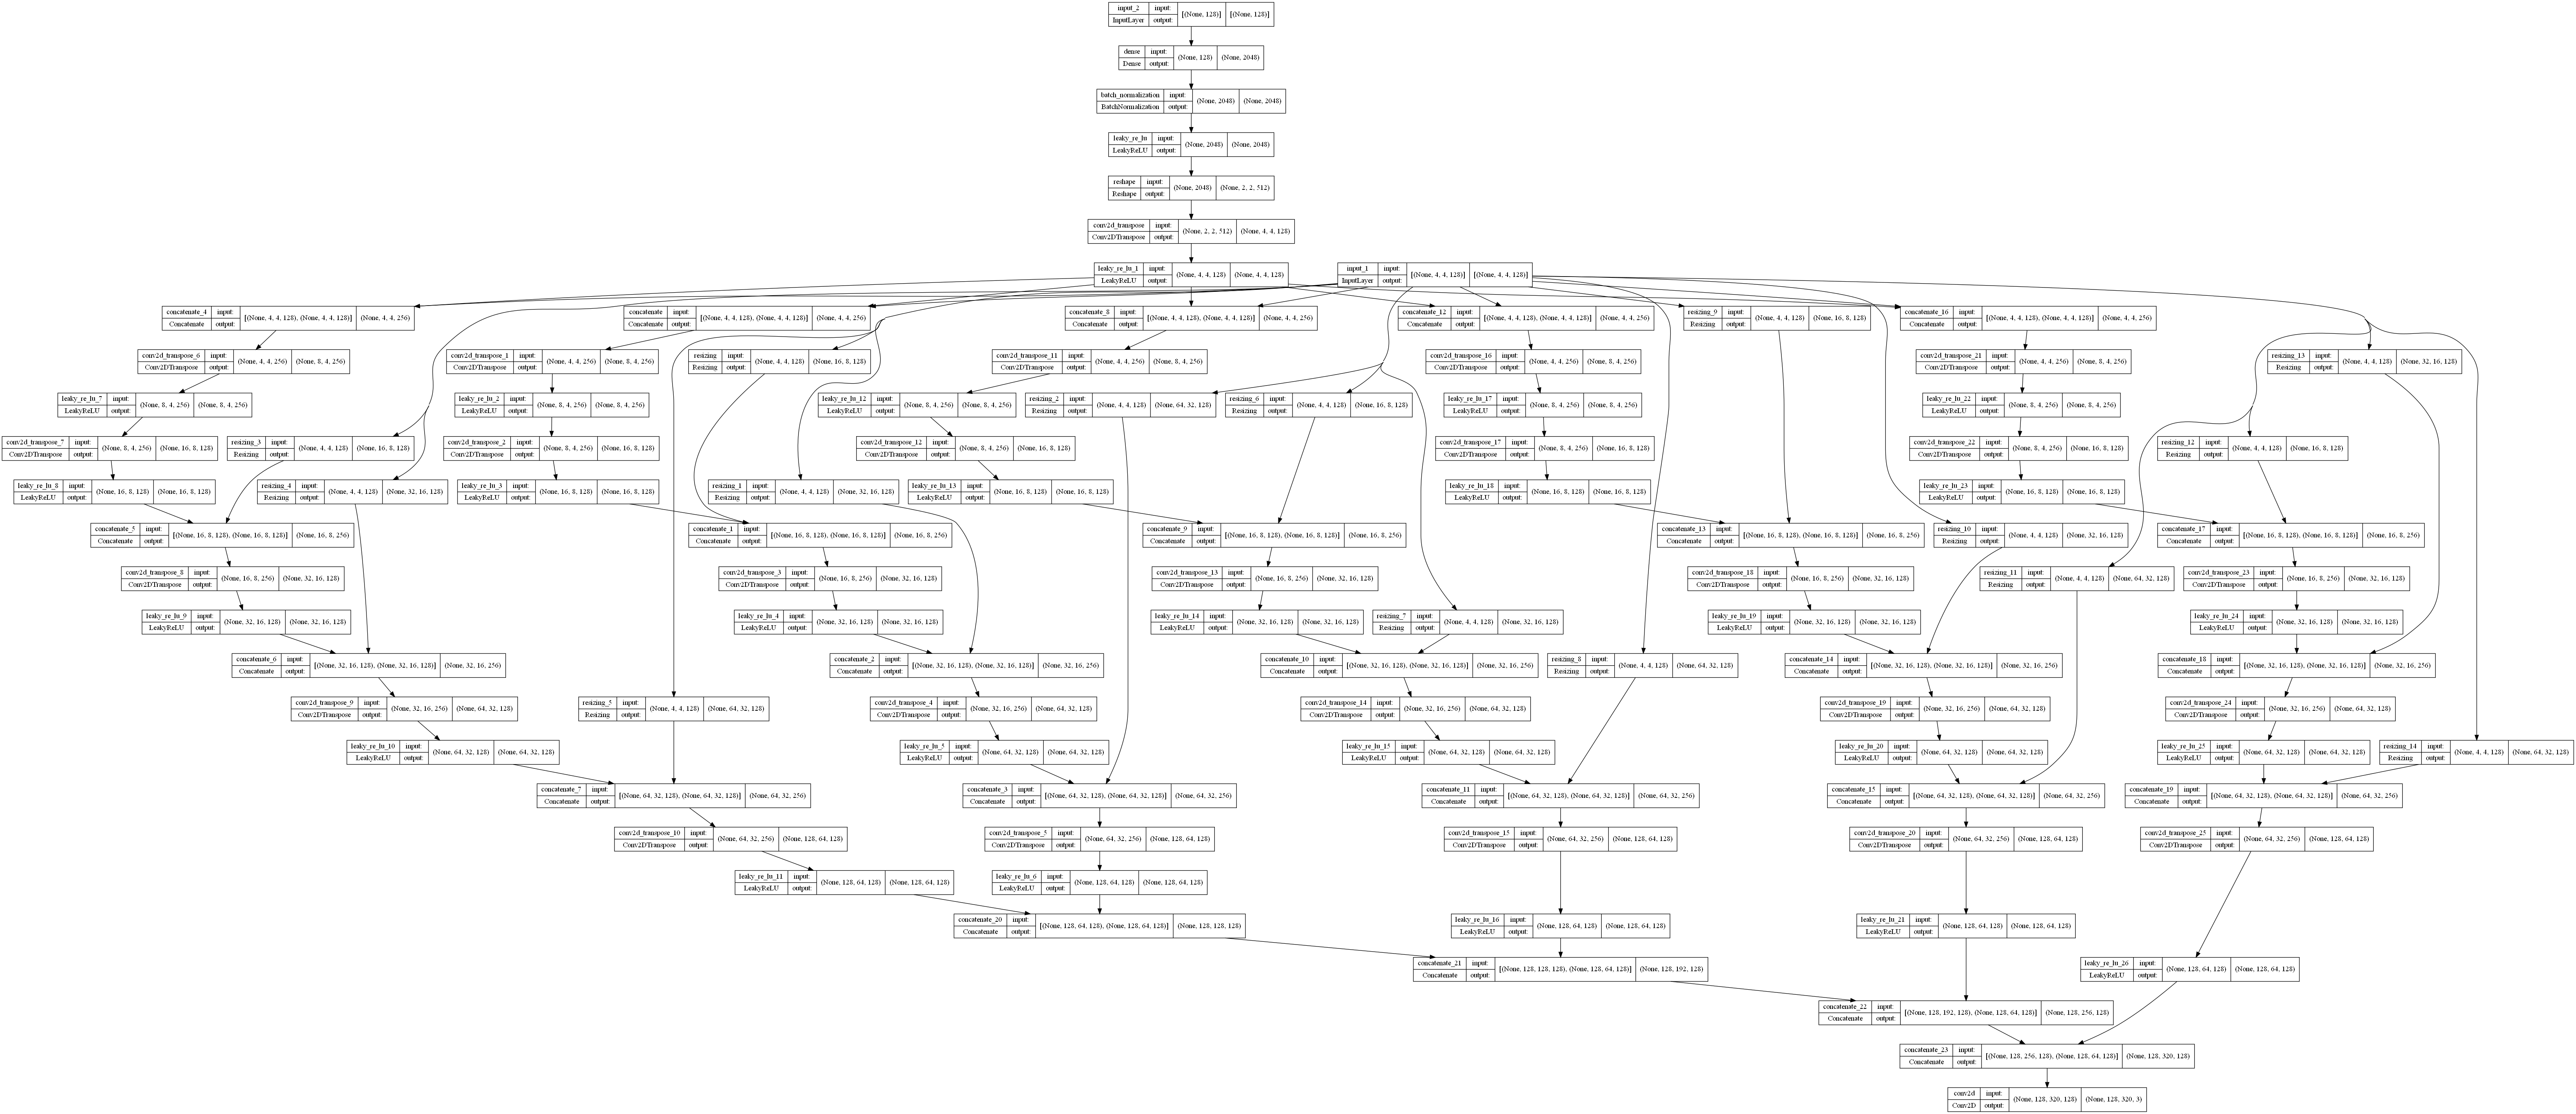

In [4]:
model = get_generator_model()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
for patient_number in range(30, 33):
    transformed_files_addr = f"DEAP_Dataset/PSDEAPTrData/t_data_s{patient_number}/all_files/"
    train_files = os.listdir(transformed_files_addr)
    labeled_gen = labeled_data_generator(train_files, transformed_files_addr,batch_size=BATCH_SIZE)

    critic = get_critic_model()
    generator = get_generator_model()
    
    generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
    discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
    wgan = WGAN(discriminator=critic, generator=generator, latent_dim=latent_dim,
                discriminator_extra_steps=3, gp_weight=5.0)
    
    wgan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer,
                g_loss_fn=generator_loss, d_loss_fn=discriminator_loss)
    
    wgan.fit(labeled_gen, epochs=epochs)
    
    wgan.generator.save(f"DEAP_Dataset/PSDEAPTrData/t_data_s{patient_number}/generator_20000_s{patient_number}_leaked_Final.h5")
    wgan.discriminator.save(f"DEAP_Dataset/PSDEAPTrData/t_data_s{patient_number}/discriminator_20000_s{patient_number}_leaked_Final.h5")